# Classificação de frutas

## Autor

Lucas Gabriel Bezerra - 180125770

GitHub: [lucasgbezerra](https://github.com/lucasgbezerra/)

## Objetivo

O objetivo deste artigo é criar e treinar um modelo capaz de classificar 50 tipos de frutas a partir de uma aplicação.

## Motivação

No mundo existem mais de 1400 frutas, sendo muitas dessas frutas semelhantes devido á uma série de fatores dentre eles a modificação geneticas das sementes das frutas.

Visto essa dificuldade de classificação, e a futura necessidade de robôs alocarem frutas nos seus devidos locais em mercados surgiu a ideia de criar uma aplicação capaz de classificar uma fruta dentre 50 tipos a partir de uma imagem.

## Modelagem

## Passo 1 - Instalando depêndencias

- Instalação da biblioteca DuckDuckGo, com o gerenciador de pacotes pip, para realizar a busca pelas imagens utilizadas para o treinamento do modelo e realização de testes.

- Instalação da biblioteca de deep learning fastai.

In [1]:
!pip install -Uqq duckduckgo_search fastai

## Passo 2 - Baixando imagens

Criação de uma função para buscar imagens(limitado a 50) a partir do termo passado como paramêtro utilizando a biblioteca do motor de pesquisa DuckDuckGo.

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *

def search_images(term, max_images=100):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Buscando duas (banana, maça) imagens para verificar o funcionamento da função e para testes futuros.

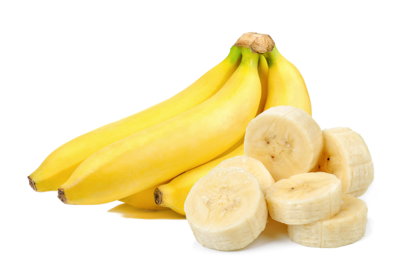

In [3]:
from fastai.vision.all import *
from fastdownload import download_url

urls = search_images('banana', max_images=1)
dest = 'banana.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(400,400)

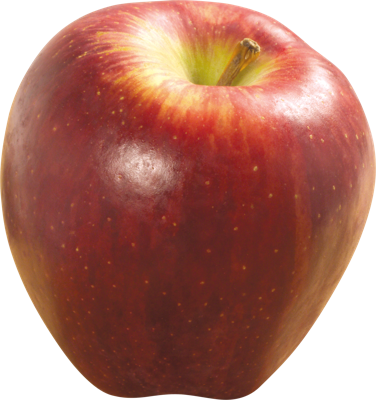

In [4]:
urls = search_images('apple', max_images=1)
dest = 'maca.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(400,400)

Lista de 40 frutas populares que serão utilizadas para pesquisa e como label dos conjuntos de imagens.

In [5]:
list_fruits = [
'Açaí',
'Acerola',
'Apple',
'Avocado',
'Banana',
'Blackberry',
'Blueberry',
'Cherry',
'Cloudberry',
'Coconut',
'Cranberry',
'Dragonfruit',
'Elderberry',
'Feijoa',
'Fig',
'Grape',
'Grapefruit',
'Guava',
'Jabuticaba',
'Jackfruit',
'Jambul',
'Kiwifruit',
'Lemon',
'Lime',
'Lychee',
'Mango',
'Melon',
'Watermelon',
'Nectarine',
'Orange',
'Tangerine',
'Papaya',
'Passionfruit',
'Peach',
'Pineapple',
'Raspberry',
'Star fruit',
'Strawberry',
'Tamarind',
'Tayberry']

Utilizando a função criada para buscar imagens, vamos buscar um conjunto de imagens das diferentes frutas. 

As imagens serão reduzidas e salvas em diretórios, onde cada pasta contem imagens de uma raça, para uso posterior.

In [6]:
searches = list_fruits
path = Path('fruits')

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'fruit {o}'))
    sleep(1)
    resize_images(path/o, max_size=400, dest=path/o)


Antes de realizar o treinamento do modelo é indicado realizar uma verificação das imagens baixadas, a fim de buscar imagens que possam ter sido baixadas incorretamente e dessa forma possam causar falha no modelo treinado. As imagens baixadas incorretamente serão excluidas.

In [8]:
failed_imgs = verify_images(get_image_files(path))
failed_imgs.map(Path.unlink)
print(f"Número de imagens incorretas: {len(failed_imgs)}")

Número de imagens incorretas: 42


### Passo 2 - Formantando conjunto de Imagens

Antes de realizar o treinamento do modelo um bloco de dados será gerado.

O **Datablock** é composto por diversos parâmetros, os parâmetros utilizados nessa modelagem foram:
- *blocks=(ImageBlock, CategoryBlock)*: o tipo de entrada(imagens de cachorro) e saídas (categorias ou raças de cachorros)
- *get_items=get_image_files*: retorna as lista de imagens armazenadas no path
- *splitter=RandomSplitter(valid_pct=0.2, seed=42)*: Divisão do dado entre conjunto de validação e de treinamento, sendo 20% dos dados para validação
- *get_y=parent_label*: o valor y é o nome do 'pai' de cada arquivo, que no caso em questão é a pasta com o a raça dele.
- *item_tfms=[Resize(192, method='squish')]*: reduz o tamanho da imagem antes do treinamento para 192x192 pixels.

In [9]:
fruits = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

### Data augmentation
A fim de melhorar o desempenho do treinamento, e visto a baixa quantidade de dados disponíveis (30 para cada fruta), uma estratégia de transformação das imagens será usada. 

O Data augmentation é a criação de variações aleatórias dos dados de entrada, de tal forma que elas pareção diferentes, apesar de serem a mesma image.

Algumas informações sobre métodos e funções usadas: 
- *aug_transforms* é um padrão de augmentations indicado na aula e com boa performance para imagens de fotos naturais.
- *batch_tfms* é um método do fastai que indica o uso dessas transformações.
- *RandomResizedCrop*: Recorta e redimenciona de maneira aleátoria a imagem

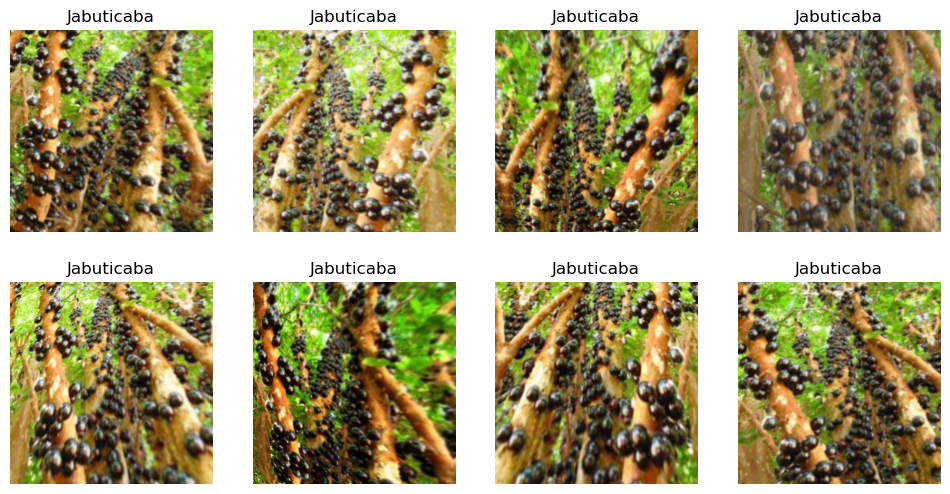

In [10]:
fruits = fruits.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms(mult=2))
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Passo 3 - Treinando o modelo e usando isso para limpar os dados

Criando o *learner* e o fine-tune.

Para treinar o modelo foi utilizado o modelo de visão(*vision model*) **resnet18**.

Além disso o fastai possui o **fine_tune()** que é um método para 'tunar' um modelo, onde ele parte de pesos de uma rede treinada para treinar o modelo desejado.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

/home/lucas/miniconda3/envs/fastai_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/lucas/miniconda3/envs/fastai_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,3.548712,1.281487,0.356863,02:44


epoch,train_loss,valid_loss,error_rate,time
0,1.601093,0.958774,0.261438,04:07
1,1.269263,0.783368,0.209150,03:50
2,1.005181,0.708753,0.205229,03:49
3,0.831804,0.634011,0.171242,03:39
4,0.670481,0.616937,0.172549,03:37
5,0.551518,0.587587,0.164706,03:38
6,0.466246,0.578071,0.162092,03:39
7,0.406304,0.573479,0.159477,03:38


### Matriz de confusão
A matriz de confusão é uma maneira de ver quais erros estão sendo cometidos pelo modelo, quais as frutas que ele mais confunde.

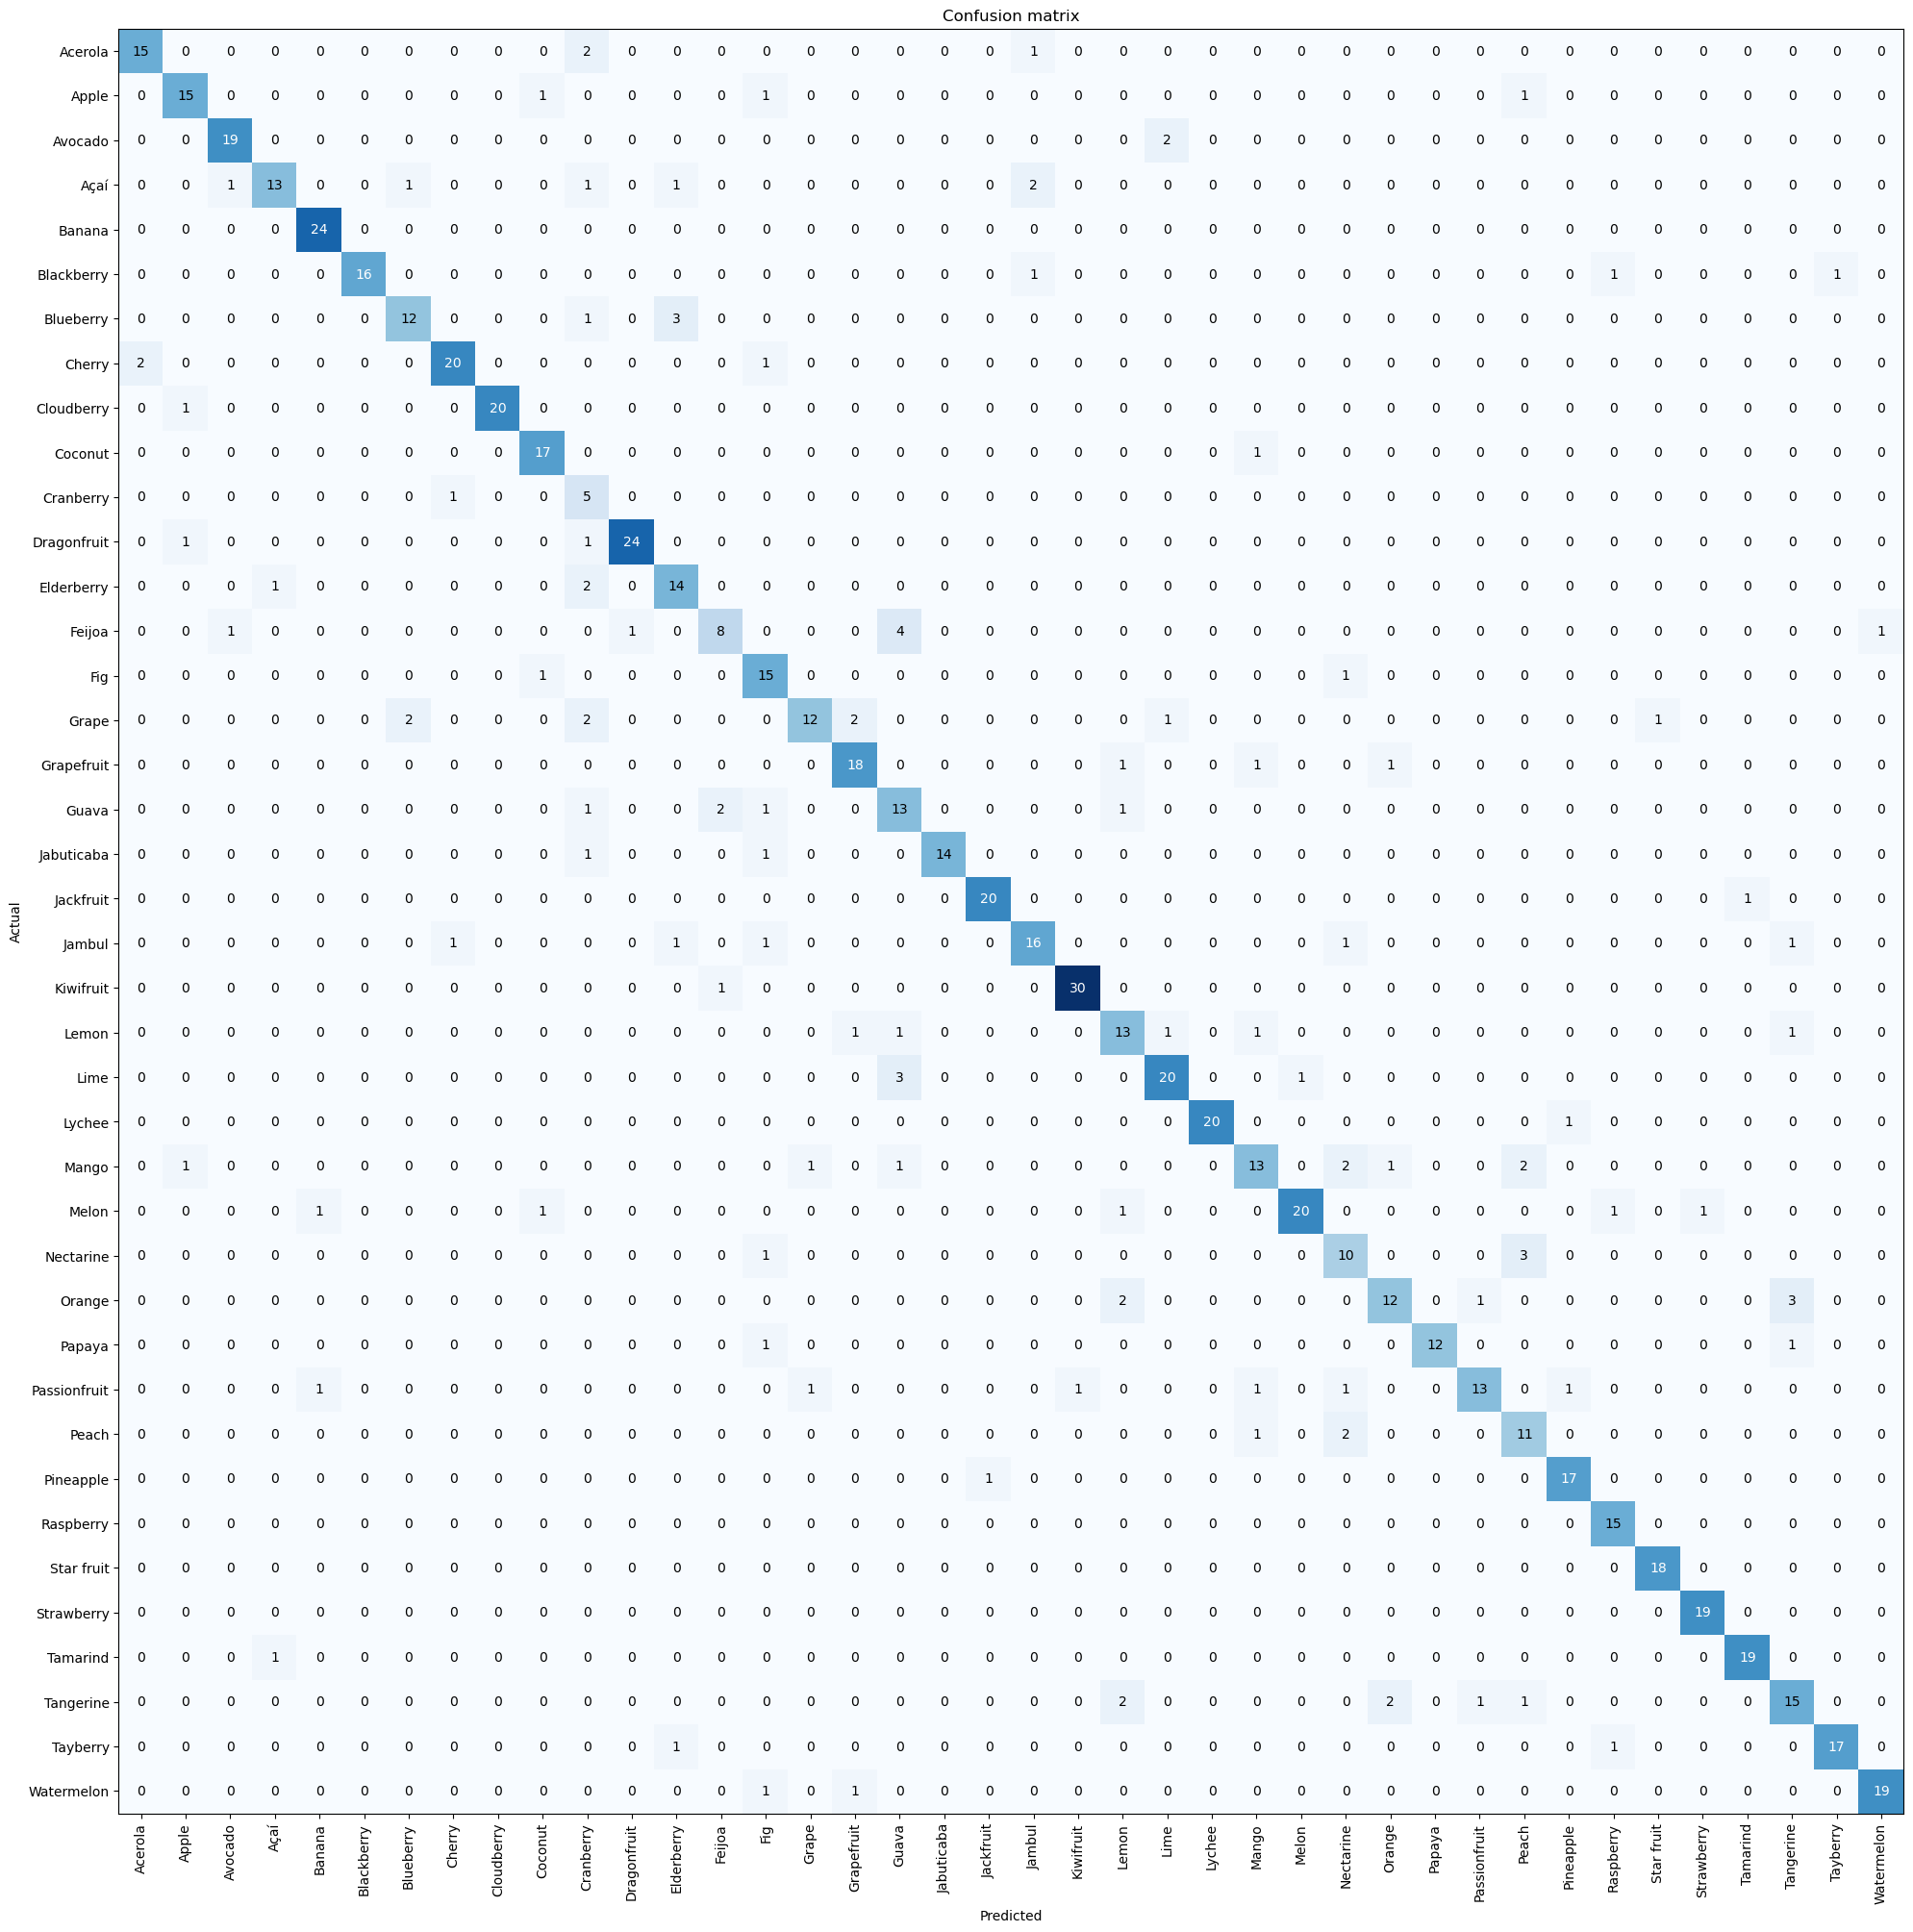

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(20,20))

As colunas da matriz representam as imagens de frutas que o modelo prediz, e as linhas representam o conjunto de imagens de frutas utilizadas no treinamento.

A diagonal principal representa os acertos (predição condiz com a label). Enquanto as outras intercessões mostram os erros cometidos, sendo quanto maior o número de uma celula mais vezes ocorreu a confusão.

Para entender melhor o que os erros mostram (um erro do modelo ou das imagens) pode ser útil ordenar as imagens pela perda (loss).

**Quanto mais incorreto é o modelo maior a perda (loss)**, especialmente quando o erro ocorre com alta confiança. A perda (loss) também é alta quando a predição está correta porém com pouca confiança na resposta.

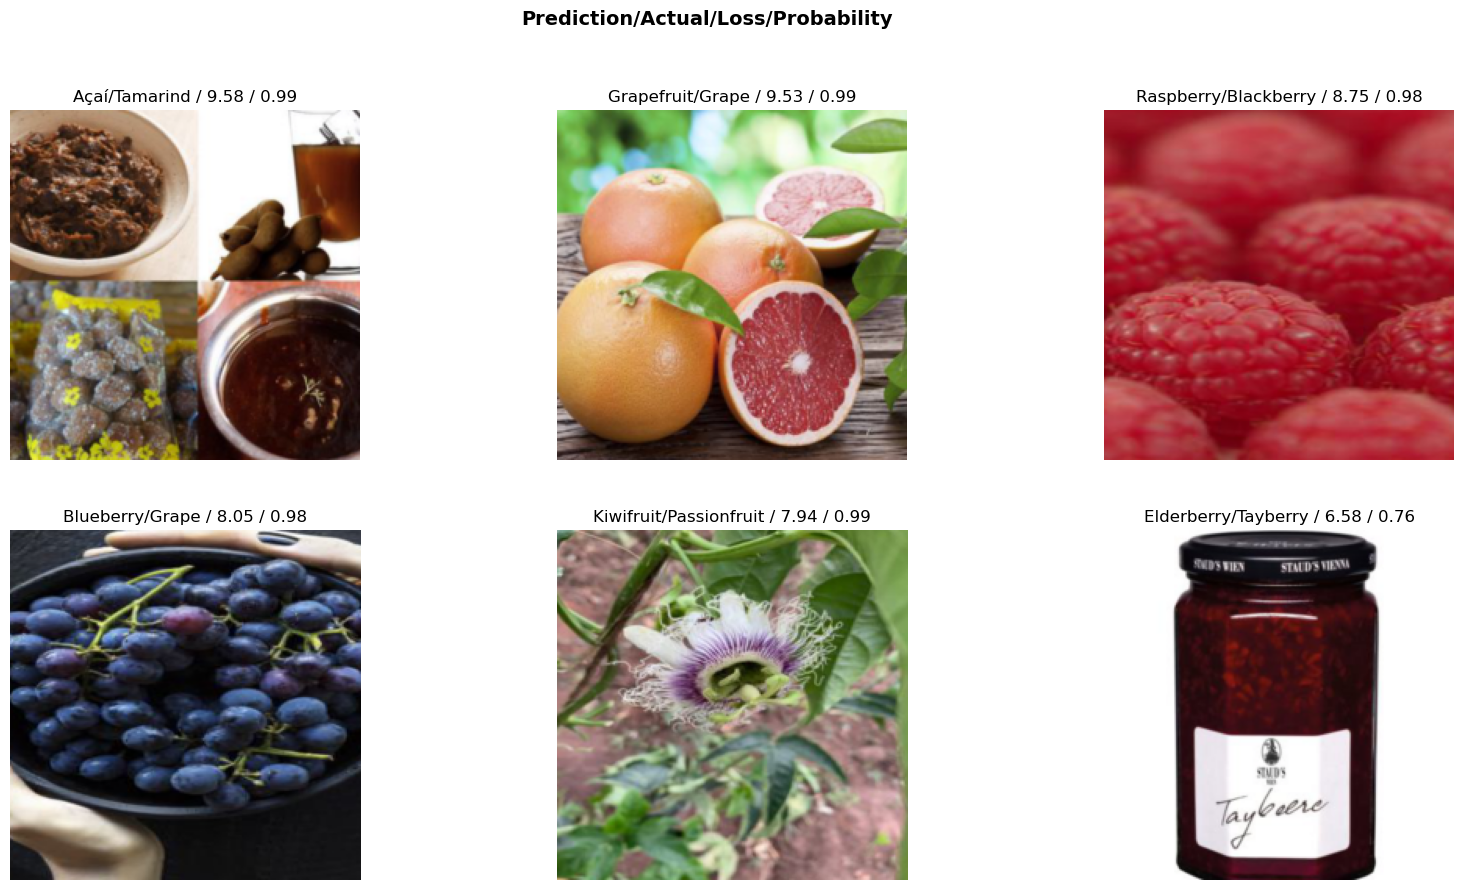

In [13]:
interp.plot_top_losses(6, figsize=(20,10))

Algumas das imagens foram confusões justas devido a semelhança, como é o caso da Blueberry e Grape. Em outros casos a confusão se dá pela imagem baixada ser de outro produto que não o desejado, por exemplo a grapefruit ( que está taxada como grape(uva)

Após esse processo o modelo auxiliou a identificar onde o dado pode ser mais problemático de maneira rápida.

Para melhorar o conjunto de dados é preciso fazer uma **limpeza dos dados**. O fastai possui uma GUI para isso chamada *ImageClassifierCleaner*, essa GUI será usada para selecionar imagens para remoção ou realocar.

In [14]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

Para realizar as remoções e realocamento das imagens indicadas basta utilizar esses 2 loops:

In [21]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Uma vez que ocorre a limpeza dos dados, o modelo pode ser **re-treinado** e alcançar melhores resultados.

In [22]:
dls = fruits.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,3.515037,0.986208,0.281073,02:27


epoch,train_loss,valid_loss,error_rate,time
0,1.488720,0.720482,0.194915,03:23
1,1.194612,0.577371,0.175141,03:25
2,0.944714,0.502537,0.142655,03:23
3,0.737673,0.463781,0.137006,03:24
4,0.596538,0.446615,0.134181,03:24
5,0.480110,0.437845,0.134181,03:23
6,0.409775,0.400782,0.112994,03:23
7,0.372343,0.399309,0.110169,03:24


## Passo 3 - Testando o modelo

Para utilizar o modelo basta usar a linha de código a seguir com uma imagem do cachorro. Será retornada a raça do cachorro e a probabilidade de correspondência obtida.

```python

data_type,_, probs = learn.predict(PILImage.create('imagem.jpg'))
```

In [23]:
fruit_type ,_, probs = learn.predict(PILImage.create('banana.jpg'))

print(f'Probabilidade de ser um {fruit_type} é de {probs.sort()[0][-1]*100:.2f}%')

Probabilidade de ser um Banana é de 98.32%


In [24]:
fruit_type ,_, probs = learn.predict(PILImage.create('maca.jpg'))

print(f'Probabilidade de ser um {fruit_type} é de {probs.sort()[0][-1]*100:.2f}%')

Probabilidade de ser um Apple é de 99.99%


## Deploy do modelo

### Exportar o modelo

O primeiro passo para realizar o deploy do modelo é necessário exportá-lo, para isso será usado o método export() do learner

In [25]:
learn.path = Path('.')
learn.export()

### Deploy no huggin Face

Seguindo os passos descritos no hugging face. Um space foi criado, clonado e o arquivo app.py foi criado.

O arquivo **app.py** foi preenchido com o script:

```python
import gradio as gr
from fastai.vision.all import *

learn = load_learner('export.pkl')
labels = learn.dls.vocab

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Fruit Classifier"
examples = ['banana.jpg', 'jabuticaba.jpeg', 'laranja.jpg',  'maca.jpg', 'melancia.jpeg']

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.inputs.Image(shape=(512, 512)),
    outputs=gr.outputs.Label(num_top_classes=3),
    title=title,
    examples=examples,
    )
iface.launch(inline=False)
```

O repositório com o **deploy** pode ser acessado no [huggingFace](https://huggingface.co/spaces/lucasgbezerra/fruit_classifier)

## Conclusão

Classificar uma grande quantidade de dados é custoso e mais difícil, usar o RandomResizedCrop, permitiu diminuir o número de dados de entrada para treinar o modelo e isso foi muito útil para diminuir o tempo de download de imagens.

Outro ponto importante da execução desse artigo foi a utilização do treinamento para facilitar a identificação de confusões com a matriz de confução e o melhoramento da base de dados com o *ImageClassifierCleaner()*, Isso ficou nítido após o retreino, com a mesma base de dados porém otimizada a precisão se mostrou maior.